In [1]:
# pip install -e git+git://github.com/sensiblecodeio/databaker.git@solo-cleaned#egg=databaker

import xlutils
import xypath
import databaker

import databaker.constants
from databaker.constants import *
import databaker.databakersolo as ds
from databaker.jupybakeutils import HDim, savepreviewhtml, savepreviewhtmlBAGS, writetechnicalCSV, procrows, TechnicalCSV


ImportError: cannot import name 'savepreviewhtml'

In [2]:
tableset = xypath.loader.table_set("rftmatables_tcm77-415727.xls", extension='xls')
tabs = list(xypath.loader.get_sheets(tableset, "*"))   

conversionsegments = [ ]
for tab in tabs:
    if tab.name == "Table 1":
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        dimensions = [
            HDim(anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            HDim(anchor.expand(RIGHT).parent().is_not_blank(), 'Companies', CLOSEST, LEFT),
            HDim(anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT),
            HDim(anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank(), 'Transaction', CLOSEST, LEFT),
            HDim(anchor.expand(DOWN).is_not_blank().is_bold(), 'TIMETYPE', CLOSEST, ABOVE)   
        ]
        conversionsegments.append((tab, dimensions, obs))
        
    elif tab.name in ['Table 2', 'Table 3', 'Table 4', 'Table 5']:
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        inv1 = anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank()
        inv1 = inv1 | tab.excel_ref('B4')

        dimensions = [
            HDim(inv1, 'Investment', CLOSEST, LEFT), 
            HDim(anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            HDim(anchor.expand(RIGHT).parent().is_not_blank(), 'Category', CLOSEST, LEFT), 
            HDim(inv1, 'Investment', CLOSEST, LEFT), 
            HDim(anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT), 
            HDim(tab.excel_ref('C1'), 'Category', CLOSEST, ABOVE), 
            HDim(anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), "Measure", CLOSEST, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 6", "Table 7"]:
        
        my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
                   "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9'  }
        for P1, corner in my_dict.items():
            if P1[0] != tab.name[-1]:
                continue
    
            anchor = tab.filter(contains_string(corner))
            obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

            # Getting all the junk out of the file
            unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
            obs = obs - unwanted    
            cat = tab.filter(contains_string(P1[0:2])).shift(RIGHT)
            dimensions = [
                HDim(anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Area", CLOSEST, LEFT), 
                HDim(anchor.shift(0, -1).expand(RIGHT).is_not_blank(), MEASURETYPE, DIRECTLY, ABOVE), 
                HDim(anchor.shift(-1, 0).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT),
                HDim(cat, "Mergers", CLOSEST, ABOVE)
            ]
            conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 8", "Table 10"]:
        anchor = tab.excel_ref('C3')
        
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref('R1').expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
        measure_line = anchor.shift(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - measure_line.shift(RIGHT).expand(DOWN)
        
        dimensions = [
            HDim(anchor.expand(RIGHT).is_not_blank(), "Category", CLOSEST, LEFT), 
            HDim(measure_line, MEASURETYPE, DIRECTLY, ABOVE), 
            HDim(anchor.shift(LEFT).expand(DOWN).is_bold(), "TIME - DELETEME", CLOSEST, ABOVE), 
            HDim(anchor.shift(LEFT).expand(DOWN).is_not_bold().is_not_blank(), TIME, DIRECTLY, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))
    
    elif tab.name in ["Table 9"]:
        anchor = tab.filter(contains_string ('Total')).assert_one()

        dimensions = [ 
            HDim(anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Expenditure", CLOSEST, LEFT), 
            
            # this is the one gives the word "cash" and might want to be left or right above, although this is unsatisfactory
            # might be better to be able to displace it to the right (provide an offset) which we can then do CLOSEST RIGHT on
            HDim(anchor.shift(0, -1).expand(RIGHT).is_not_blank(), "Expenditure 1", CLOSEST, LEFT),  
            
            HDim(anchor.expand(RIGHT).is_not_blank(), "Expenditure 2", CLOSEST, LEFT), 
            HDim(anchor.shift(LEFT).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT), 
            HDim(anchor.shift(LEFT).expand(DOWN).is_bold(), "ExtraTime", CLOSEST, ABOVE), 
        ]
        # Get obs,and get rid of lots of crap    
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref("V1").expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ("earliest revision")).expand(RIGHT).expand(DOWN)
        obs = obs - anchor.expand(RIGHT).is_not_blank().shift(RIGHT).fill(DOWN)
        conversionsegments.append((tab, dimensions, obs))

            
print("There are %d conversion segments" % len(conversionsegments))
print([c[0].name for c in conversionsegments])

There are 16 conversion segments
['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 6', 'Table 6', 'Table 6', 'Table 7', 'Table 7', 'Table 7', 'Table 7', 'Table 8', 'Table 9', 'Table 10']


In [23]:
# Preview a conversion segment inline or on second screen 
from databaker.jupybakeutils import dsubsets, tabletohtml, sidewindowhtmldisplay, inlinehtmldisplay, incrementdividNUM, inlinehtmljsactive
conversionsegment = conversionsegments[10]
tab, dimensions, segment = conversionsegment
htmtable = tabletohtml(tab, dsubsets(dimensions, segment))

incrementdividNUM()
inlinehtmldisplay(htmtable, hide=False)
inlinehtmljsactive(conversionsegment)
#sidewindowhtmldisplay()
#document.getElementsByClassName()



In [4]:
print("converting and writing %d conversion segments" % (len(conversionsegments)))
convertedrows = [ ]
for conversionsegment in conversionsegments:
    print("conversion segment size %d" % len(conversionsegment[2]))
    rows = procrows(conversionsegment)
    convertedrows.append(rows)
    
# Should detect errors and throw up preview with cells marked
# (though actually the errors manifest further upstream, normally)
    
# here we can do further sorting and postprocessing and allocating to different files 

#writetechnicalCSV(outputfile, conversionsegments)



converting and writing 16 conversion segments
conversion segment size 304
conversion segment size 88
conversion segment size 88
conversion segment size 88
conversion segment size 88
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 100
conversion segment size 222
conversion segment size 296
conversion segment size 222


/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010²'
  warnings.warn("Couldn't identify date {!r}".format(date))
/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010 Q1² '
  warnings.warn("Couldn't identify date {!r}".format(date))
/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010³'
  warnings.warn("Couldn't identify date {!r}".format(date))
/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010¹'
  warnings.warn("Couldn't identify date {!r}".format(date))
/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010 Q1¹'
  warnings.warn("Couldn't identify date {!r}".format(date))
/home/goatchurch/sensiblecode/src/databaker/databaker/utils.py:47: UserWarning: Couldn't identify date '2010 Q1²'
  warnings.warn("Couldn'

In [10]:
allvalues = [ ]
for convertedrow in convertedrows:
    allvalues.extend(convertedrow)
    

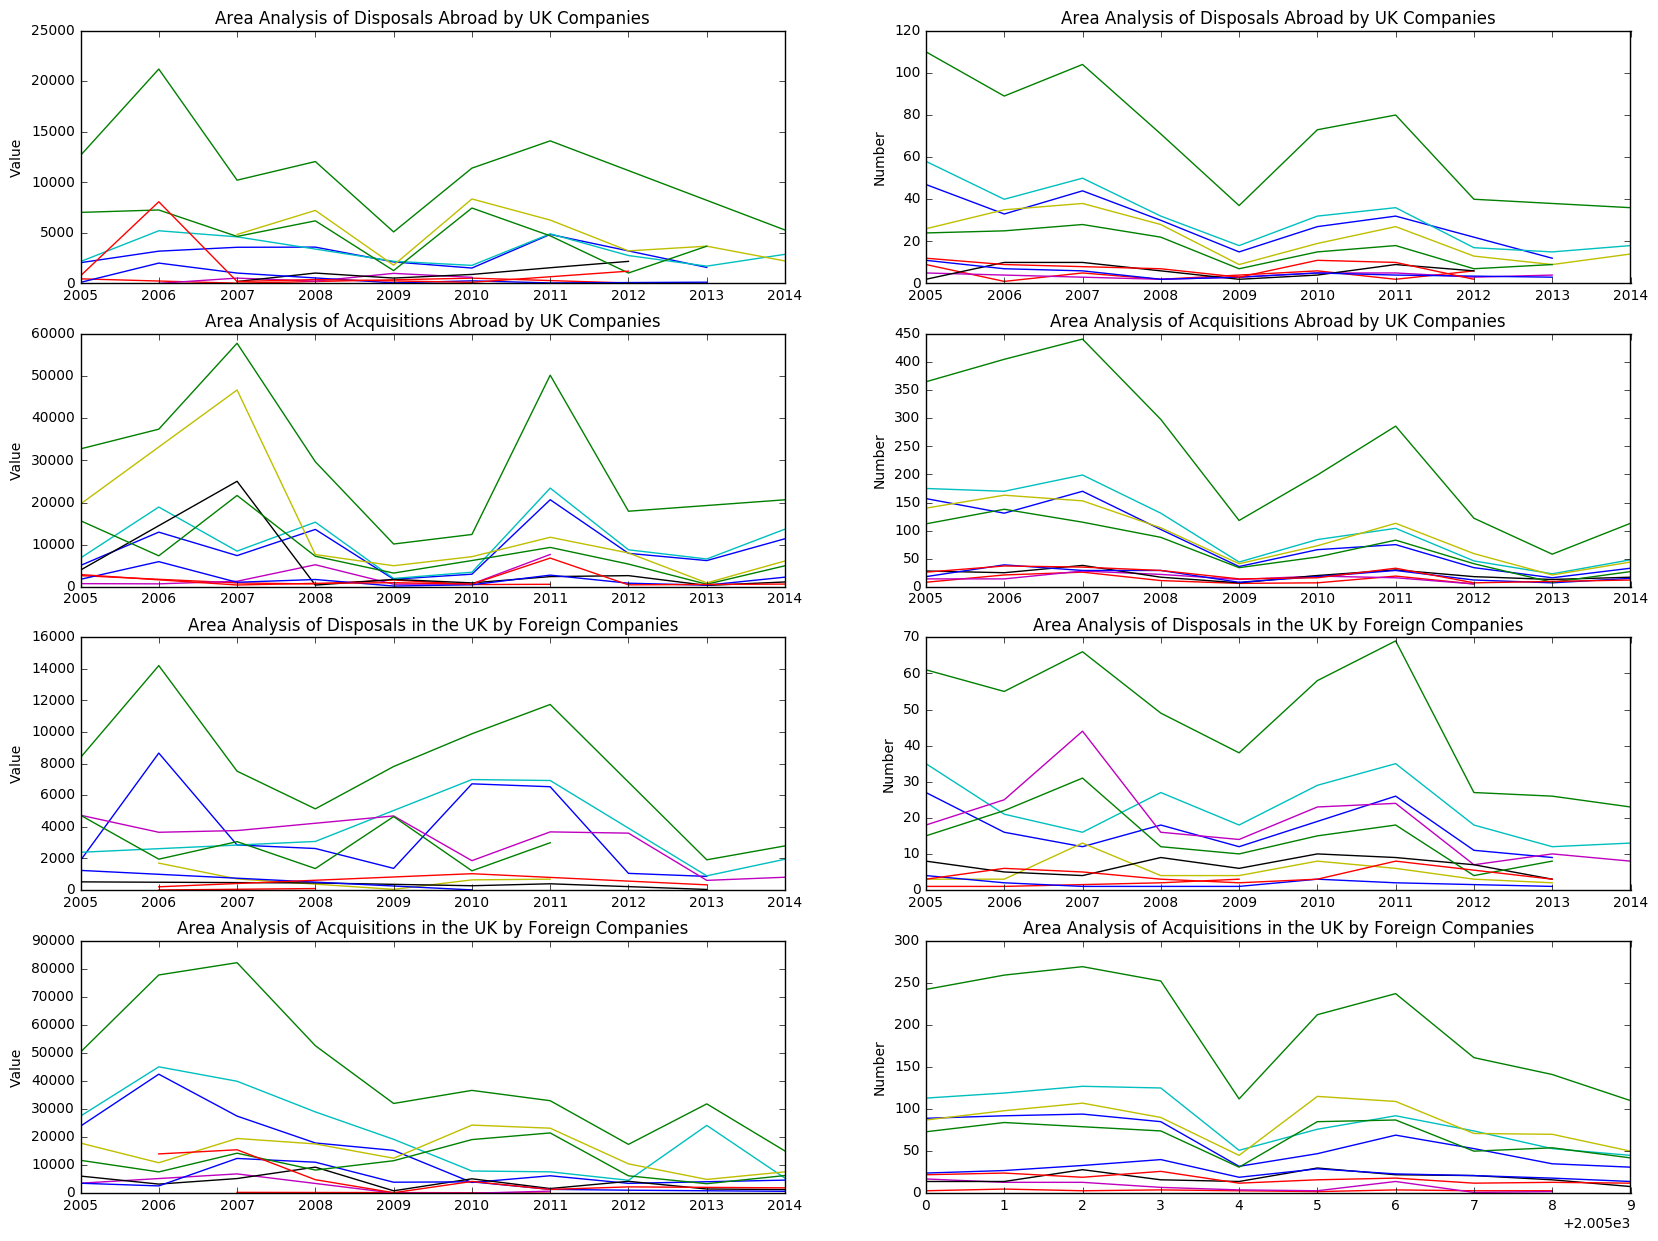

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))

mallvalues = [v  for v in allvalues  if v.get("Mergers")]
MEASURETYPEset = set(v[MEASURETYPE]  for v in mallvalues)
mergerset = set(v["Mergers"]  for v in mallvalues)

for i, merger in enumerate(mergerset):
    for j, sMEASURETYPE in enumerate(MEASURETYPEset):
        values = [v  for v in mallvalues  if (v["Mergers"] == merger and v[MEASURETYPE] == sMEASURETYPE) ]
        areas = set(v['Area']  for v in values)

        ax = plt.gca()
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax.get_xaxis().get_major_formatter().set_scientific(False)

        plt.subplot(len(mergerset), len(MEASURETYPEset), i*len(MEASURETYPEset)+j+1)
        def pairplot(plt, vp, label):
            vp.sort()
            plt.plot([v[0] for v in vp], [v[1] for v in vp], label=label)
        for area in areas:
            vp = [ ]
            for v in values:
                if v["Area"] == area and v[MEASURETYPE] == sMEASURETYPE and type(v[OBS]) is not str:
                    year = v[TIME]
                    if type(year) == str:
                        year = int(year[:4])  # crappy footnotes
                    vp.append((year, v[OBS]))
            pairplot(plt, vp, area)
        #plt.legend()
        #print(merger, sMEASURETYPE, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == "Value"])
        #break
        plt.title(values[0]["Mergers"])
        plt.ylabel(sMEASURETYPE)
plt.show()


In [21]:
# alternatively, using pivot table (made by Peter)
import pandas as pd
df = ( 
    pd.DataFrame.from_records(mallvalues)
    .rename(columns={-6:"MEASURETYPE", -2:"TIME", -9:"OBS"})
    .assign(TIME=lambda df:df.TIME.astype(int))
    #.assign(TIME2=lambda df:df.TIME.astype(int)*2)
)

pdf = df.pivot_table("OBS", ["TIME"], ["Mergers", "MEASURETYPE", "Area"])
# ["Area Analysis of Acquisitions Abroad by UK Companies"].xs("Number", level="MEASURETYPE", axis=1).plot()
acqtypes = pdf.columns.get_level_values(0).unique()
valtypes = pdf.columns.get_level_values(1).unique()

acqtype = acqtypes[0]
valtype = valtypes[0]
pdf[acqtype][valtype].plot(legend=False, title=acqtype)


ValueError: invalid literal for int() with base 10: '2010²'